<Axes: >

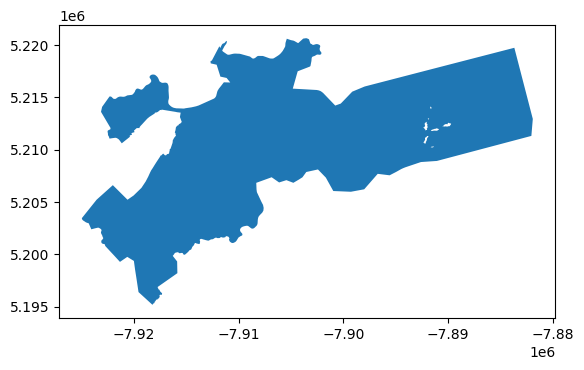

In [2]:
import osmnx as ox
import geopandas as gpd

# Get Boston city boundary
boston = ox.geocode_to_gdf("Boston, Massachusetts, USA")
boston = boston.to_crs(epsg=3857)  # Project for distance calculations

boston.plot()


In [4]:
import osmnx as ox
import geopandas as gpd

tags = {
    "shop": ["supermarket", "grocery"]
}

groceries = ox.features_from_place(
    "Boston, Massachusetts, USA",
    tags=tags
)

# Keep only point geometries
groceries = groceries[groceries.geometry.type == "Point"]

# Project for distance/network analysis
groceries = groceries.to_crs(epsg=3857)

print(len(groceries))


37


In [5]:
import pandas as pd
from shapely.geometry import Point

stops = pd.read_csv("./MBTA_GTFS/stops.txt")

transit = gpd.GeoDataFrame(
    stops,
    geometry=[Point(xy) for xy in zip(stops.stop_lon, stops.stop_lat)],
    crs="EPSG:4326"
)

transit = transit.to_crs(epsg=3857)

# Clip to Boston
transit = gpd.overlay(transit, boston, how="intersection")


In [6]:
groceries["buffer"] = groceries.geometry.buffer(1000)
transit["buffer"] = transit.geometry.buffer(500)

grocery_buffer = gpd.GeoDataFrame(
    geometry=groceries["buffer"], crs=groceries.crs
)

transit_buffer = gpd.GeoDataFrame(
    geometry=transit["buffer"], crs=transit.crs
)


In [12]:
tracts = gpd.read_file("2020_Census_Tracts_in_Boston.shp")
tracts = tracts.to_crs(epsg=3857)


In [14]:
tracts["grocery_access"] = tracts.geometry.apply(
    lambda x: grocery_buffer.intersects(x).sum()
)

tracts["transit_access"] = tracts.geometry.apply(
    lambda x: transit_buffer.intersects(x).sum()
)

tracts["access_score"] = (
    tracts["grocery_access"] * 2 +
    tracts["transit_access"]
)

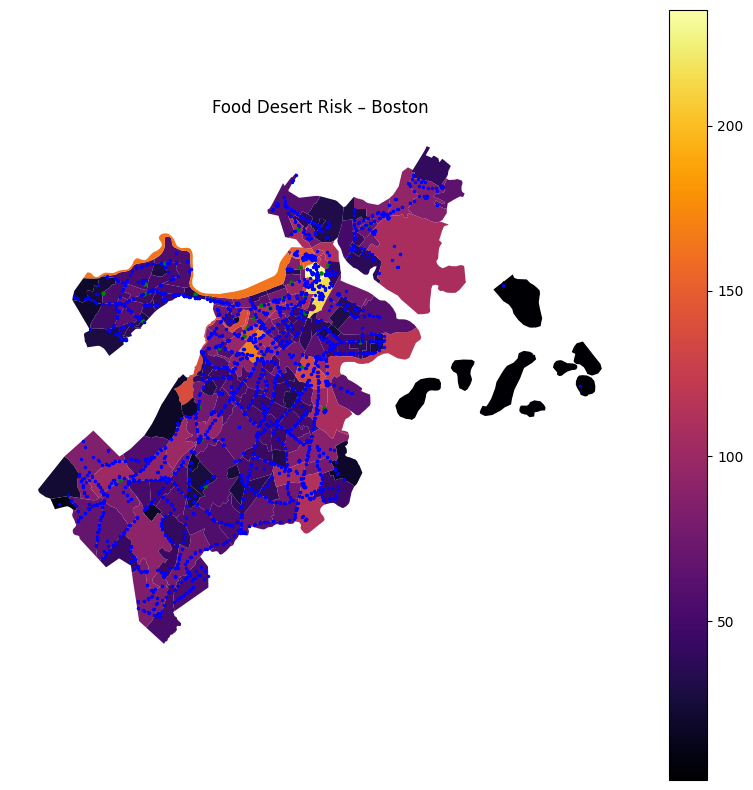

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

tracts.plot(
    column="access_score",
    cmap="inferno",
    legend=True,
    ax=ax
)

groceries.plot(ax=ax, color="green", markersize=5)
transit.plot(ax=ax, color="blue", markersize=2)

ax.set_title("Food Desert Risk – Boston")
ax.axis("off")

plt.show()
